# Basic Neural Network (MLP) — Visual Guide

This notebook demonstrates a **basic feed‑forward neural network** (multi‑layer perceptron, MLP) on a 2D dataset.
- A **baseline MLP** decision boundary (ReLU)
- **Training curves** (loss over epochs)
- Effects of **hidden units** and **layers**
- **L2 regularization** (`alpha`) and **early stopping**
- **Batch size** and **learning rate** tweaks
- A quick view of learned **weights** (first layer)

Use `sklearn.neural_network.MLPClassifier` for simplicity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt, warnings

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

np.random.seed(33)
warnings.filterwarnings("ignore")

# Nonlinear 2D dataset
X, y = make_moons(n_samples=500, noise=0.5, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=33, stratify=y
)

def plot_boundary_mlp(clf, X_tr, y_tr, X_te, y_te, title):
    # Grid
    x_min, x_max = X[:,0].min()-0.8, X[:,0].max()+0.8
    y_min, y_max = X[:,1].min()-0.8, X[:,1].max()+0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    XY = np.c_[xx.ravel(), yy.ravel()]

    # Probability of class 1 (MLP exposes predict_proba)
    P = clf.predict_proba(XY)[:,1].reshape(xx.shape)

    # Plot decision regions and probability contours
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, P>=0.5, alpha=0.15)
    CS = plt.contour(xx, yy, P, levels=[0.1,0.3,0.5,0.7,0.9], linestyles=["--","--","-","--","--"])
    plt.clabel(CS, inline=True, fontsize=8, fmt="p=%.1f")

    # Points
    plt.scatter(X_tr[:,0], X_tr[:,1], s=12, alpha=0.7, label="train")
    plt.scatter(X_te[:,0], X_te[:,1], s=16, alpha=0.9, marker="x", label="test")

    acc_tr = accuracy_score(y_tr, clf.predict(X_tr))
    acc_te = accuracy_score(y_te, clf.predict(X_te))
    plt.title(f"{title}\nacc(train)={acc_tr:.3f} | acc(test)={acc_te:.3f}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()

def train_mlp(hidden=(20,), activation="relu", alpha=1e-4, lr=0.001,
              batch_size=64, max_iter=400, early_stop=False, random_state=33):
    clf = make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=hidden, activation=activation,
                      alpha=alpha, learning_rate_init=lr, batch_size=batch_size,
                      max_iter=max_iter, early_stopping=early_stop,
                      n_iter_no_change=10, random_state=random_state)
    )
    clf.fit(X_train, y_train)
    return clf

## 1) Baseline MLP (ReLU, one hidden layer)

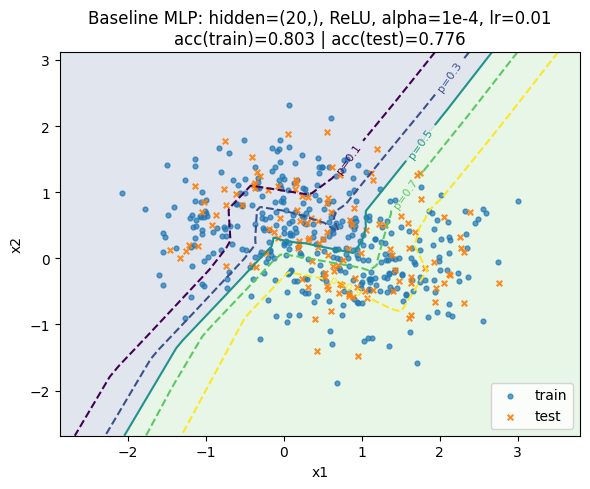

In [2]:
clf_base = train_mlp(hidden=(20,), activation="relu", alpha=1e-4, lr=0.01, batch_size=64, max_iter=800, early_stop=False)
plot_boundary_mlp(clf_base, X_train, y_train, X_test, y_test, "Baseline MLP: hidden=(20,), ReLU, alpha=1e-4, lr=0.01")

## 2) Training curve (loss over epochs)

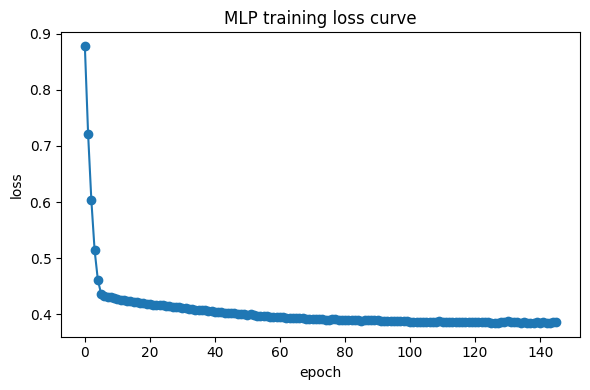

In [3]:
mlp = clf_base.named_steps["mlpclassifier"]
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_, marker="o")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("MLP training loss curve")
plt.tight_layout(); plt.show()

## 3) Hidden units sweep

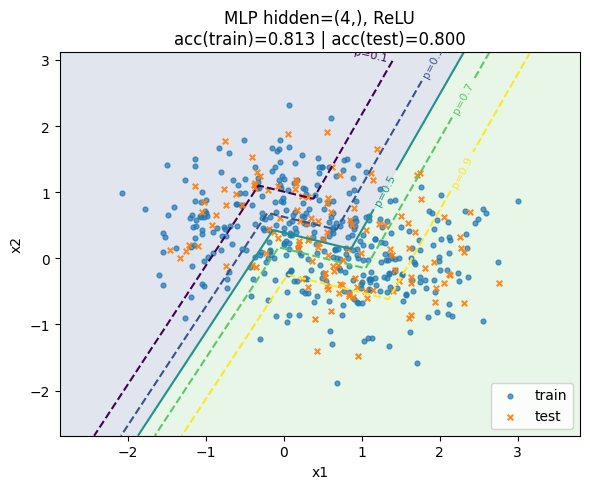

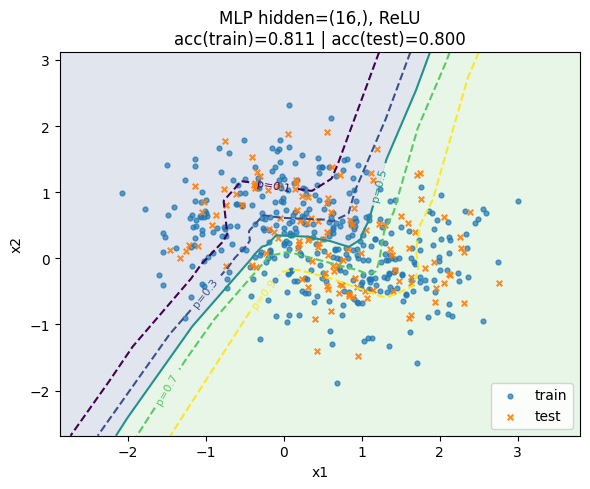

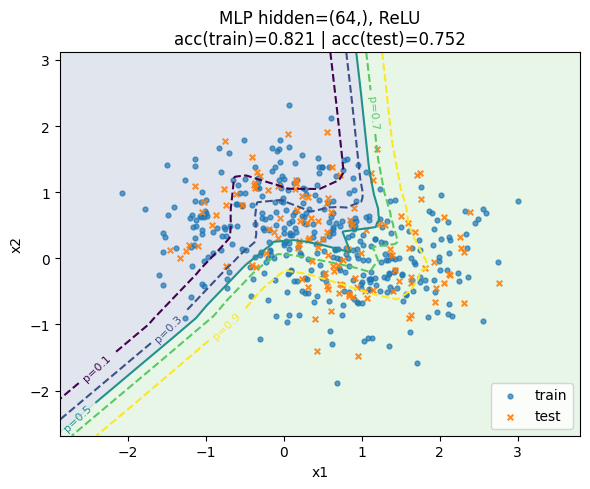

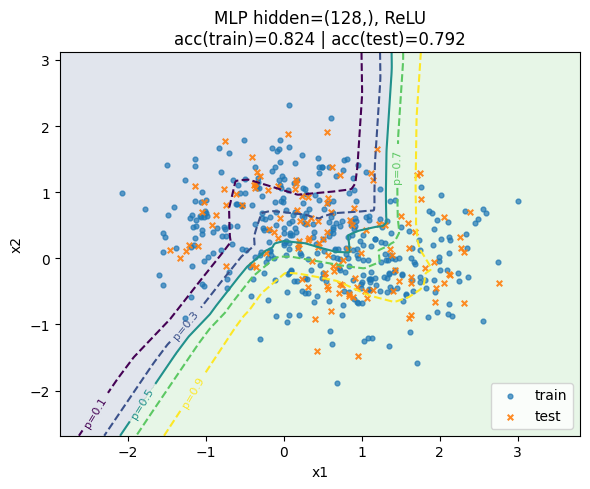

In [4]:
for h in [(4,), (16,), (64,), (128,)]:
    clf = train_mlp(hidden=h, activation="relu", alpha=1e-4, lr=0.01, batch_size=64, max_iter=800)
    plot_boundary_mlp(clf, X_train, y_train, X_test, y_test, f"MLP hidden={h}, ReLU")

## 4) Depth sweep (number of hidden layers)

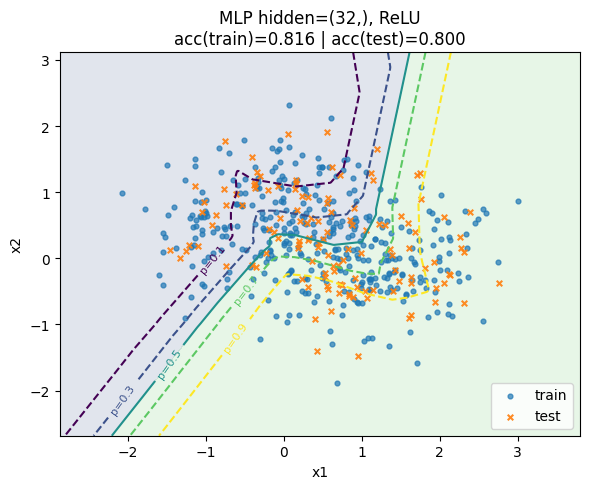

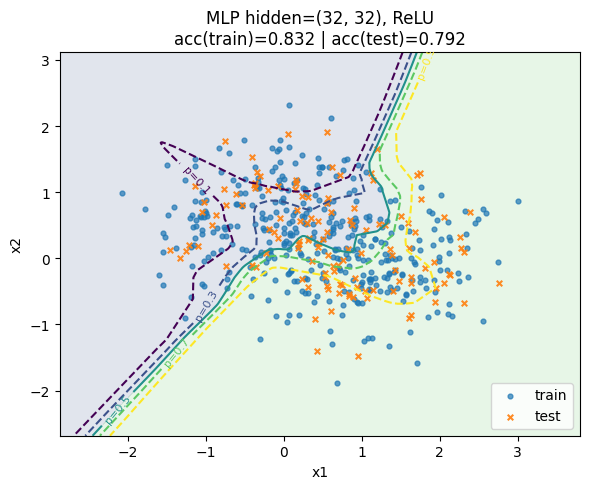

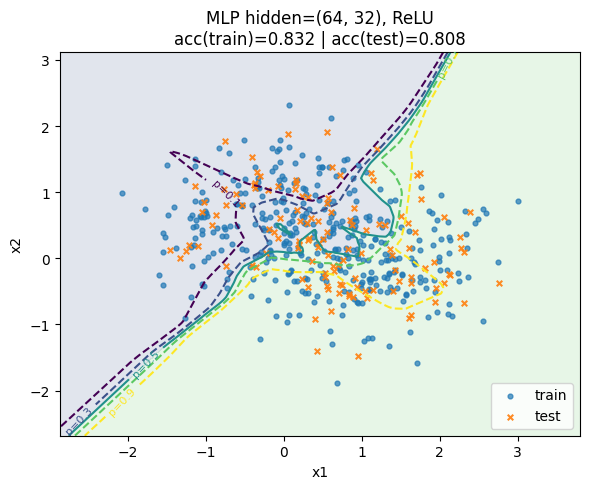

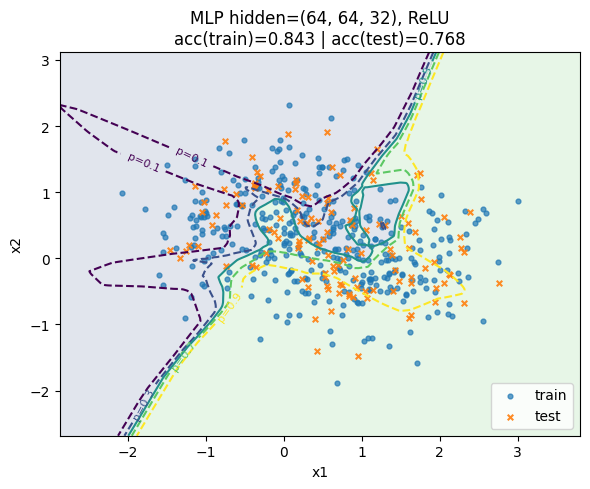

In [5]:
for h in [(32,), (32,32), (64,32), (64,64,32)]:
    clf = train_mlp(hidden=h, activation="relu", alpha=1e-4, lr=0.01, batch_size=64, max_iter=1000)
    plot_boundary_mlp(clf, X_train, y_train, X_test, y_test, f"MLP hidden={h}, ReLU")

## 5) L2 regularization (alpha) sweep

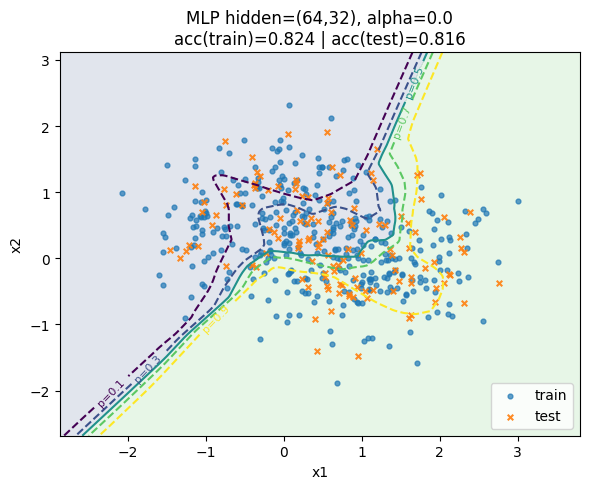

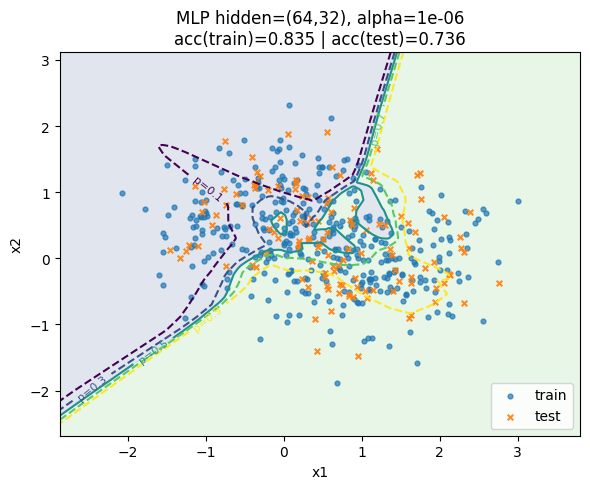

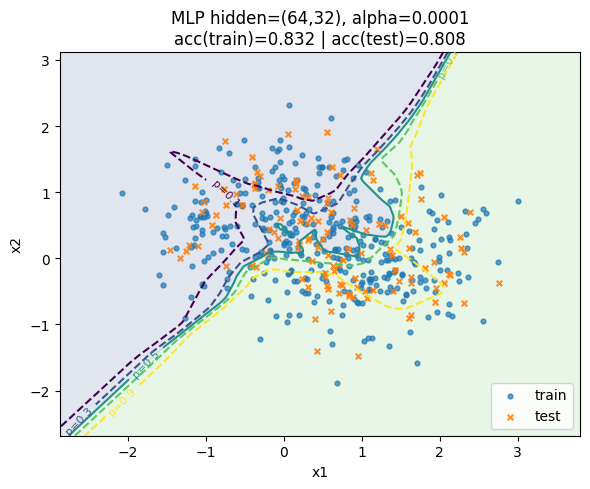

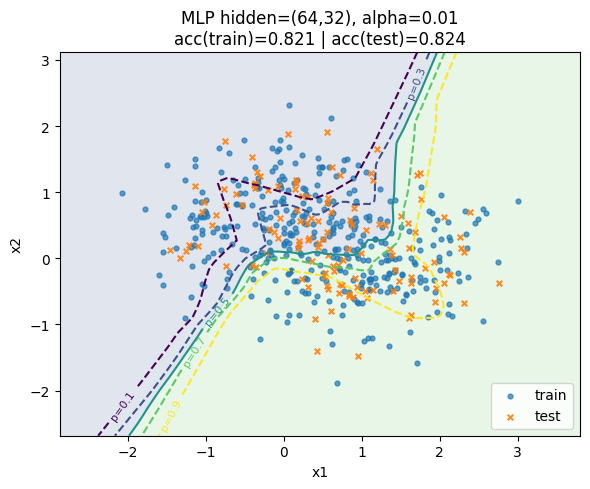

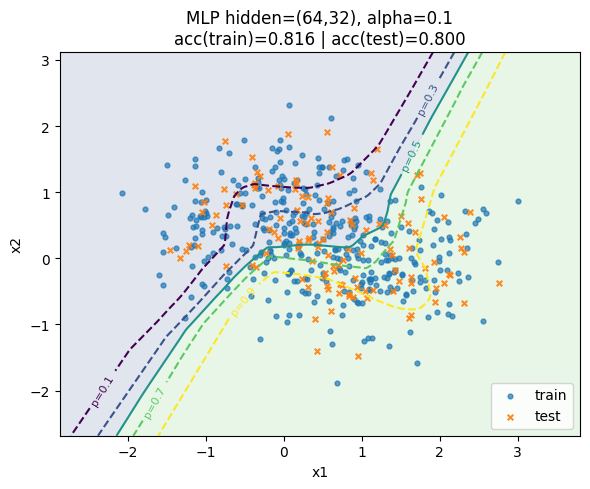

In [6]:
for a in [0.0, 1e-6, 1e-4, 1e-2, 1e-1]:
    clf = train_mlp(hidden=(64,32), activation="relu", alpha=a, lr=0.01, batch_size=64, max_iter=1000)
    plot_boundary_mlp(clf, X_train, y_train, X_test, y_test, f"MLP hidden=(64,32), alpha={a}")

## 6) Early stopping and learning rate

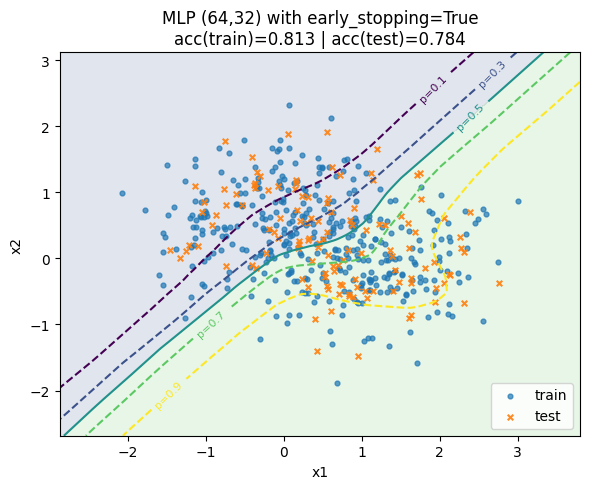

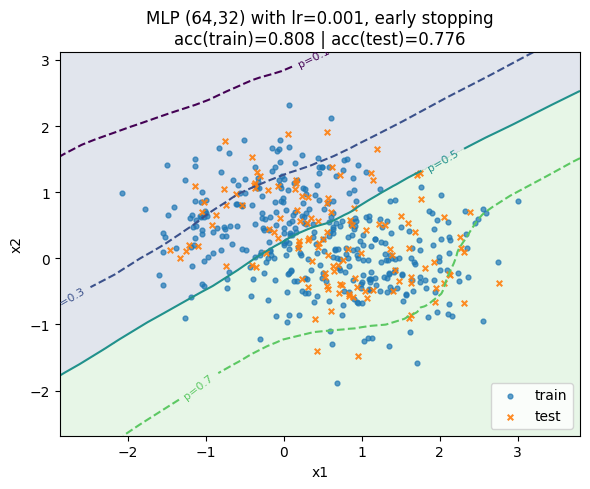

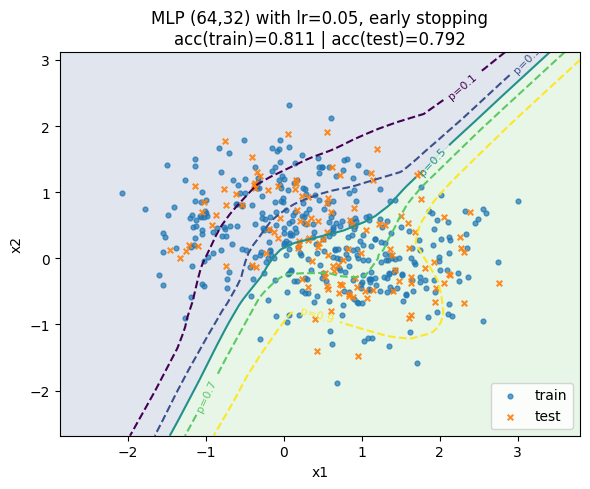

In [7]:
# Early stopping enabled
clf_es = train_mlp(hidden=(64,32), activation="relu", alpha=1e-4, lr=0.01, batch_size=64, max_iter=400, early_stop=True)
plot_boundary_mlp(clf_es, X_train, y_train, X_test, y_test, "MLP (64,32) with early_stopping=True")

# Lower learning rate
clf_lr_low = train_mlp(hidden=(64,32), activation="relu", alpha=1e-4, lr=0.001, batch_size=64, max_iter=1000, early_stop=True)
plot_boundary_mlp(clf_lr_low, X_train, y_train, X_test, y_test, "MLP (64,32) with lr=0.001, early stopping")

# Higher learning rate (may overshoot)
clf_lr_high = train_mlp(hidden=(64,32), activation="relu", alpha=1e-4, lr=0.05, batch_size=64, max_iter=600, early_stop=True)
plot_boundary_mlp(clf_lr_high, X_train, y_train, X_test, y_test, "MLP (64,32) with lr=0.05, early stopping")

## 7) Batch size sweep

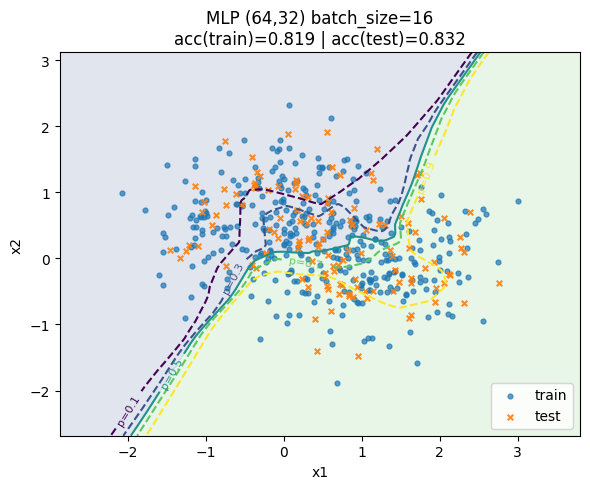

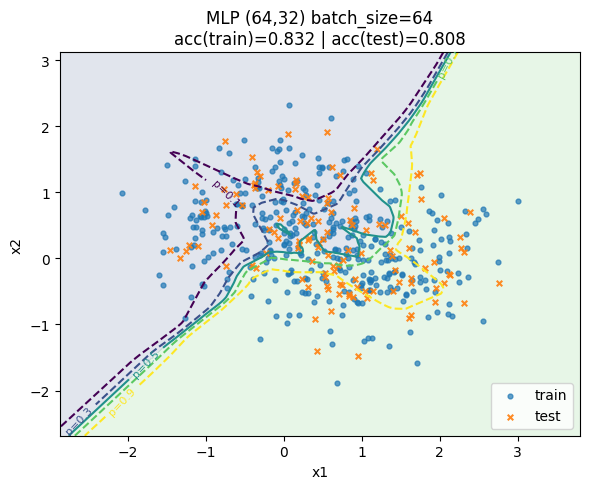

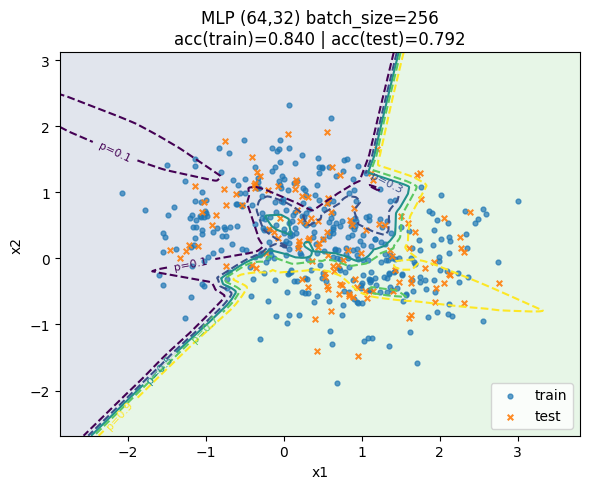

In [8]:
for b in [16, 64, 256]:
    clf = train_mlp(hidden=(64,32), activation="relu", alpha=1e-4, lr=0.01, batch_size=b, max_iter=800)
    plot_boundary_mlp(clf, X_train, y_train, X_test, y_test, f"MLP (64,32) batch_size={b}")

## 8) Activation comparison (tanh vs relu)

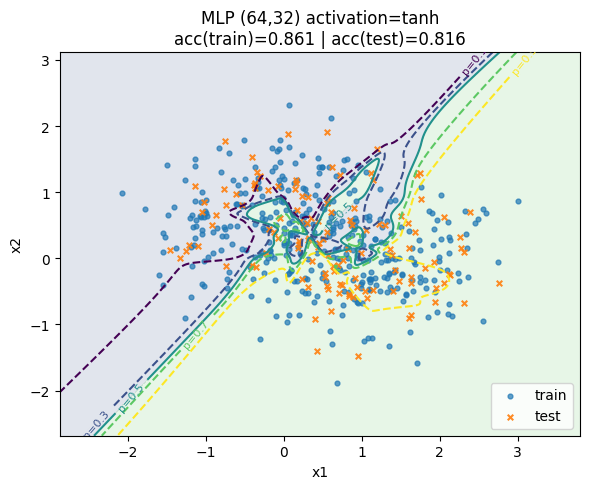

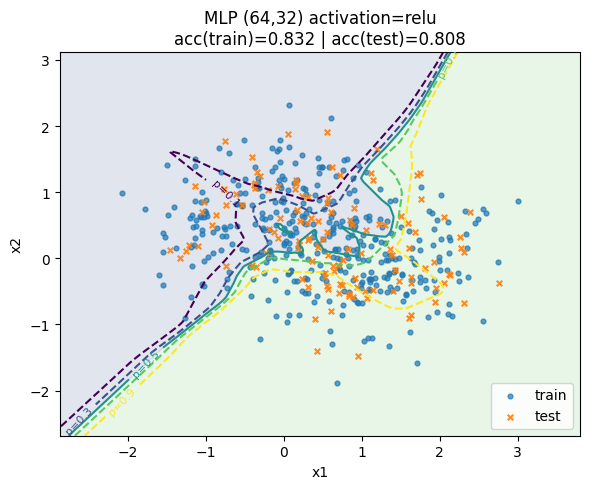

In [9]:
for act in ["tanh", "relu"]:
    clf = train_mlp(hidden=(64,32), activation=act, alpha=1e-4, lr=0.01, batch_size=64, max_iter=1000)
    plot_boundary_mlp(clf, X_train, y_train, X_test, y_test, f"MLP (64,32) activation={act}")

## 9) First-layer weights (heatmap)

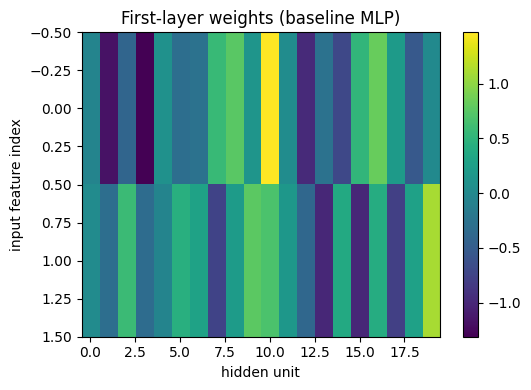

In [10]:
# Use the baseline model
mlp = clf_base.named_steps["mlpclassifier"]
W = mlp.coefs_[0]  # shape: [n_features, n_hidden]
plt.figure(figsize=(5.5,4))
plt.imshow(W, aspect="auto")
plt.colorbar()
plt.title("First-layer weights (baseline MLP)")
plt.xlabel("hidden unit"); plt.ylabel("input feature index")
plt.tight_layout(); plt.show()